# Cranfield dataset processing

This notebook creates vector space model for documents and queries contained in [Cranfield](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/) collection.

In [149]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

Helper functions. `get_top_n()` simply returns indices of top ten relevant documents for each query. `get_precision()` returns precision, recall and f-score for a query (represented by query index and top ten documents retrieved).

In [150]:
def get_top_n(matrix, n=10):
    return np.array([ matrix[i].argsort()[-n:][::-1]+1 for i in range(225)])

def get_precision(query_index, retrieved):
    relevant = []
    with open('cranfield/r/{}.txt'.format(query_index)) as f:
        for line in f:
            relevant.append(int(line))

    tp = 0
    fn = 0
    fp = 0

    for doc in relevant:
        if doc in retrieved:
            tp += 1
        else:
            fn += 1 

    for doc in retrieved:
        if doc not in relevant:
            fp += 1

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    if p == 0 or r == 0:
        f = 0
    else:
        f = 2 * ((p * r)/(p + r))
    
    return p, r, f

def get_prf_dict(top_retrieved):
    prf = {
        'p' : np.array([0.] * len(top_retrieved)),
        'r' : np.array([0.] * len(top_retrieved)),
        'f' : np.array([0.] * len(top_retrieved)),
    }
    
    for idx, top in enumerate(top_retrieved):
        prf['p'][idx] = get_precision(idx + 1, top)[0]
        prf['r'][idx] = get_precision(idx + 1, top)[1]
        prf['f'][idx] = get_precision(idx + 1, top)[2]
    
    return prf

Here we prepare corpus of documents and queries for processing. Note that `corpus[:1400]` contains documents and `corpus[1400:]` contains queries.

In [151]:
corpus = []

for d in range(1400):
    f = open("cranfield/d/"+str(d+1)+".txt")
    corpus.append(f.read())
    f.close()
for q in range(225):
    f = open("cranfield/q/"+str(q+1)+".txt")
    corpus.append(f.read())
    f.close()

Initialization of different vectorizers we are going to use to create vector space model.
* TFIDF vectorizer -- calculates [TFIDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) score for each document or query
* Count vectorizer -- counts term in each document or query
* Binary vectorizer -- 1 if term is present in document/query, 0 otherwise

In [152]:
tfidf_vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()
binary_vectorizer = CountVectorizer(binary=True)

Matrices with dimensions (1625 -- number of documents and queries, 20679 -- total number of terms) for each vectorizer. Matrix rows are vector of given vector space models (each row represent document or query).

In [153]:
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
count_matrix = count_vectorizer.fit_transform(corpus)
bin_matrix = binary_vectorizer.fit_transform(corpus)

Calculate similarity between queries and documents using given vector space model (TFIDF, count, binary) and distance measure (cosine similiarity, euclidean distance). Each matrix has dimensions (225, 1400), each element represents similarity betweent one query and one document.

In [154]:
r_tfidf_cos = np.array(cosine_similarity(tfidf_matrix[1400:], tfidf_matrix[:1400]))
r_tfidf_euc = np.array(pairwise_distances(tfidf_matrix[1400:], tfidf_matrix[:1400]))

r_count_cos = np.array(cosine_similarity(count_matrix[1400:], count_matrix[:1400]))
r_count_euc = np.array(pairwise_distances(count_matrix[1400:], count_matrix[:1400]))

r_bin_cos = np.array(cosine_similarity(bin_matrix[1400:], bin_matrix[:1400]))
r_bin_euc = np.array(pairwise_distances(bin_matrix[1400:], bin_matrix[:1400]))

Get indices of 10 most relevant documents for each query using given vector space model and distance measure.

In [155]:
top_relevant_tfidf_cos = get_top_n(r_tfidf_cos)
top_relevant_tfidf_euc = get_top_n(r_tfidf_euc)

top_relevant_count_cos = get_top_n(r_count_cos)
top_relevant_count_euc = get_top_n(r_count_euc)

top_relevant_bin_cos = get_top_n(r_bin_cos)
top_relevant_bin_euc = get_top_n(r_bin_euc)


In [156]:
tfidf_cos_prf = get_prf_dict(top_relevant_tfidf_cos)
tfidf_euc_prf = get_prf_dict(top_relevant_tfidf_euc)

count_cos_prf = get_prf_dict(top_relevant_count_cos)
count_euc_prf = get_prf_dict(top_relevant_count_euc)

bin_cos_prf = get_prf_dict(top_relevant_bin_cos)
bin_euc_prf = get_prf_dict(top_relevant_bin_euc)

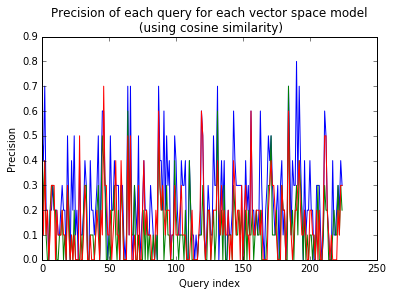

In [176]:
plt.plot(tfidf_cos_prf['p'])
plt.plot(count_cos_prf['p'])
plt.plot(bin_cos_prf['p'])
plt.title('Precision of each query for each vector space model\n (using cosine similarity)')
plt.xlabel('Query index')
plt.ylabel('Precision')
plt.show()

In [171]:
tfidf_mean_p = (tfidf_cos_prf['p'].mean(), tfidf_euc_prf['p'].mean())
tfidf_max_p = (tfidf_cos_prf['p'].max(), tfidf_euc_prf['p'].max())
print('Mean precision for TFIDF (cos sim) = {}, (euc dist) = {}'.format(tfidf_mean_p[0], tfidf_mean_p[1]))
print('Max precision for TFIDF (cos sim) = {}, (euc dist) = {}'.format(tfidf_max_p[0], tfidf_max_p[1]))

Mean precision for TFIDF (cos sim) = 0.2408888888888889, (euc dist) = 0.0013333333333333335
Max precision for TFIDF (cos sim) = 0.8, (euc dist) = 0.1


In [172]:
count_mean_p = (count_cos_prf['p'].mean(), count_euc_prf['p'].mean())
count_max_p = (count_cos_prf['p'].max(), count_euc_prf['p'].max())
print('Mean precision for count (cos sim) = {}, (euc dist) = {}'.format(count_mean_p[0], count_mean_p[1]))
print('Max precision for count (cos sim) = {}, (euc dist) = {}'.format(count_max_p[0], count_max_p[1]))

Mean precision for count (cos sim) = 0.1288888888888889, (euc dist) = 0.006222222222222223
Max precision for count (cos sim) = 0.7, (euc dist) = 0.1


In [173]:
bin_mean_p = (bin_cos_prf['p'].mean(), bin_euc_prf['p'].mean())
bin_max_p = (bin_cos_prf['p'].max(), bin_euc_prf['p'].max())
print('Mean precision for binary (cos sim) = {}, (euc dist) = {}'.format(bin_mean_p[0], bin_mean_p[1]))
print('Max precision for binary (cos sim) = {}, (euc dist) = {}'.format(bin_max_p[0], bin_max_p[1]))

Mean precision for binary (cos sim) = 0.14888888888888888, (euc dist) = 0.005777777777777778
Max precision for binary (cos sim) = 0.7, (euc dist) = 0.1
